In [1]:
from scapy.all import *
import sys
import matplotlib.pyplot as pyplot

## Read packets from .pcap file


In [2]:
pcap = rdpcap(r'../datasets/200000.pcap')
print('pcap', pcap)
print(len(pcap))

pcap<200000.pcap: TCP:1771 UDP:2199 ICMP:0 Other:196030>
200000


## Find all beacon packets
Because we have a lot of different packets, so if we want to find all Beacon packets, we have to set some conditions:

* pcap\[i\].haslayer(Dot11) 
* type = 0 and subtype = 8
* info = 'siqcomm-nat' and beacon interval = 200

In [138]:
tsf = []
time = []
packets = []

for i in range(0, len(pcap)):
    if pcap[i].haslayer(Dot11):
        if pcap[i].type == 0 and pcap[i].subtype == 8:
            if hasattr(pcap[i], 'info'):
                if (pcap[i].info == b'sigcomm-nat' and
                    pcap[i].beacon_interval == 100):
                    tsf.append(pcap[i].timestamp)
                    time.append(pcap[i].time)
                    packets.append(pcap[i])

## Calculate xi and oi

$ xi = \Delta t = local\ time $

$ \Delta T = clock - \Delta t = remote\ time\ observed $

$ oi = \Delta T - \Delta t = \Delta T - xi = - clock $

$ \Delta oi = -clock\ skew $

We have got tsf and time now, so we can analyze them and get xi and oi.

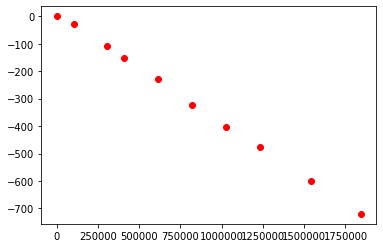

In [202]:
xi = []
oi = []
oo = 1

for i in range(0, len(tsf)):
    xi.append((time[i] - time[0]) * pow(10, 6))
    oi.append((tsf[i] - tsf[0]) - xi[i])

# plot first 10 points(xi, oi)
plt.plot(xi[0:10], oi[0:10], 'ro')
# plt.plot(xi[0:100], xi[0:100])
plt.show()

## Delete unusual datas
(oi / xi) must bigger than 0

In [203]:
# find unusual datas
weired = []
for i in range(1, len(oi)):
    if (oi[i] / xi[i] >= 0):
        print(oi[i] / xi[i])
        weired.append(i)
# delete
for i in range(0, len(weired)):
    del oi[weired[i]]
    del xi[weired[i]]

1708482254.525719996494337392
0.008728174587839592212379022368
0.02457880843817184232121275410


## Set training data and testing data

In [204]:
size = (int)(len(xi) * 0.75)
print(size)

xi_train = xi[:size]
oi_train = oi[:size]
xi_test = xi[size:]
oi_test = oi[size:]

clkSkews_true = []
for i in range(0, len(xi_test)):
    clkSkews_true.append(oi_test[i] / xi_test[i])

6333


## Do LinearRegression for getting clock offset

In [206]:
import numpy as np
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.reshape(xi_train, (len(xi_train), 1)),
        np.reshape(oi_train, (len(oi_train), 1)))

print(lm.coef_)
print(lm.intercept_)

[[-0.00039828]]
[10.88212587]
